## Setup path, autoreload, dan imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

# Tambahkan root project ke sys.path agar "src" bisa di-import dari notebook
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data_prep.clean_global_superstore import (
    load_raw_data,
    clean_global_superstore,
    save_clean_data,
)
from src.eda.eda_utils import (
    plot_sales_by_category,
    plot_sales_trend_by_month,
    plot_discount_vs_profit,
    plot_correlation_heatmap,
)

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

# Path penting
RAW_PATH = PROJECT_ROOT / "data" / "raw" / "Global_Superstore2.csv"
CLEAN_PATH = PROJECT_ROOT / "data" / "processed" / "global_superstore_clean.csv"
FIG_DIR = PROJECT_ROOT / "reports" / "figures"

FIG_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, RAW_PATH, CLEAN_PATH, FIG_DIR


(WindowsPath('D:/Coding/git-repo/github/tubes-pda/tubes-if5100-global-superstore'),
 WindowsPath('D:/Coding/git-repo/github/tubes-pda/tubes-if5100-global-superstore/data/raw/Global_Superstore2.csv'),
 WindowsPath('D:/Coding/git-repo/github/tubes-pda/tubes-if5100-global-superstore/data/processed/global_superstore_clean.csv'),
 WindowsPath('D:/Coding/git-repo/github/tubes-pda/tubes-if5100-global-superstore/reports/figures'))

## Load data mentah

In [2]:
df_raw = load_raw_data(RAW_PATH)    # pakai path eksplisit

print("Shape data mentah:", df_raw.shape)
df_raw.head()


Shape data mentah: (51290, 24)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Data understanding

###  shape & info

In [3]:
# =======================================
# 2. Data Understanding: Struktur Data
# =======================================

print("=== SHAPE DATA MENTAH ===")
print(df_raw.shape)

print("\n=== INFO DATA MENTAH ===")
df_raw.info()


=== SHAPE DATA MENTAH ===
(51290, 24)

=== INFO DATA MENTAH ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category

### Descriptive statistics

In [4]:
print("=== DESCRIPTIVE STATS (NUMERIC) ===")
display(df_raw.describe())

print("\n=== DESCRIPTIVE STATS (CATEGORICAL/OBJECT) ===")
display(df_raw.describe(include="object"))

=== DESCRIPTIVE STATS (NUMERIC) ===


,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000



=== DESCRIPTIVE STATS (CATEGORICAL/OBJECT) ===


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Market,Region,Product ID,Category,Sub-Category,Product Name,Order Priority
count,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290
unique,25035,1430,1464,4,1590,795,3,3636,1094,147,7,13,10292,3,17,3788,4
top,CA-2014-100111,18-06-2014,22-11-2014,Standard Class,PO-18850,Muhammed Yedwab,Consumer,New York City,California,United States,APAC,Central,OFF-AR-10003651,Office Supplies,Binders,Staples,Medium
freq,14,135,130,30775,97,108,26518,915,2001,9994,11002,11117,35,31273,6152,227,29433


### Nilai unik & missing values

In [5]:
print("=== JUMLAH NILAI UNIK PER KOLOM ===")
nunique = df_raw.nunique().sort_values(ascending=False)
display(nunique)

=== JUMLAH NILAI UNIK PER KOLOM ===


Row ID            51290
Order ID          25035
Profit            24575
Sales             22995
Product ID        10292
Shipping Cost     10037
Product Name       3788
City               3636
Customer ID        1590
Ship Date          1464
Order Date         1430
State              1094
Customer Name       795
Postal Code         631
Country             147
Discount             27
Sub-Category         17
Quantity             14
Region               13
Market                7
Order Priority        4
Ship Mode             4
Segment               3
Category              3
dtype: int64

In [6]:
print("=== MISSING VALUES PER KOLOM ===")
missing = df_raw.isna().sum()
display(missing[missing > 0].sort_values(ascending=False))

=== MISSING VALUES PER KOLOM ===


Postal Code    41296
dtype: int64

## Data Cleaning & Feature Engineering

In [7]:
df_clean = clean_global_superstore(df_raw)
print("Shape setelah cleaning:", df_clean.shape)
df_clean.head()

[STEP] Standardise column names...
[STEP] Parse date columns...
[STEP] Drop duplicates...


D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\src\data_prep\clean_global_superstore.py:46: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors="coerce")
D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\src\data_prep\clean_global_superstore.py:46: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors="coerce")


[INFO] Drop duplicates by ['row_id']: 0 baris dihapus.
[STEP] Handle missing values (numeric essentials)...
[INFO] Missing di kolom ['sales', 'quantity', 'profit', 'discount']: 0 baris di-drop.
[STEP] Add derived features...
[STEP] Basic type casting...
[INFO] Cleaning selesai. Shape akhir: (51290, 30)
Shape setelah cleaning: (51290, 30)


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,market,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,order_year,order_month,order_quarter,shipping_days,profit_margin,sales_per_quantity
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,2012,7,3,0,0.330000,329.950
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2013,2,1,2,-0.077847,412.155
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,2013,10,4,1,0.177766,575.019
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,2013,1,1,2,-0.033376,578.502
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,2013,11,4,1,0.109963,354.120


In [8]:
print("=== INFO SETELAH CLEANING ===")
df_clean.info()

=== INFO SETELAH CLEANING ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   row_id              51290 non-null  int64         
 1   order_id            51290 non-null  object        
 2   order_date          51290 non-null  datetime64[ns]
 3   ship_date           51290 non-null  datetime64[ns]
 4   ship_mode           51290 non-null  category      
 5   customer_id         51290 non-null  object        
 6   customer_name       51290 non-null  object        
 7   segment             51290 non-null  category      
 8   city                51290 non-null  category      
 9   state               51290 non-null  category      
 10  country             51290 non-null  category      
 11  postal_code         9994 non-null   float64       
 12  market              51290 non-null  category      
 13  region          

In [9]:
save_clean_data(df_clean, CLEAN_PATH)

[INFO] Data bersih disimpan ke: D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\data\processed\global_superstore_clean.csv


WindowsPath('D:/Coding/git-repo/github/tubes-pda/tubes-if5100-global-superstore/data/processed/global_superstore_clean.csv')

## Exploratory Data Analysis

In [10]:
numeric_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()

print("Kolom numerik:")
print(numeric_cols)

print("\nKolom kategorikal:")
print(categorical_cols)

Kolom numerik:
['row_id', 'postal_code', 'sales', 'quantity', 'discount', 'profit', 'shipping_cost', 'order_year', 'order_month', 'order_quarter', 'shipping_days', 'profit_margin', 'sales_per_quantity']

Kolom kategorikal:
['order_id', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'city', 'state', 'country', 'market', 'region', 'product_id', 'category', 'sub_category', 'product_name', 'order_priority']


### Distribusi variabel numerik (histogram)

Kolom numerik yang diplot: ['sales', 'profit', 'discount', 'quantity', 'shipping_days', 'profit_margin']


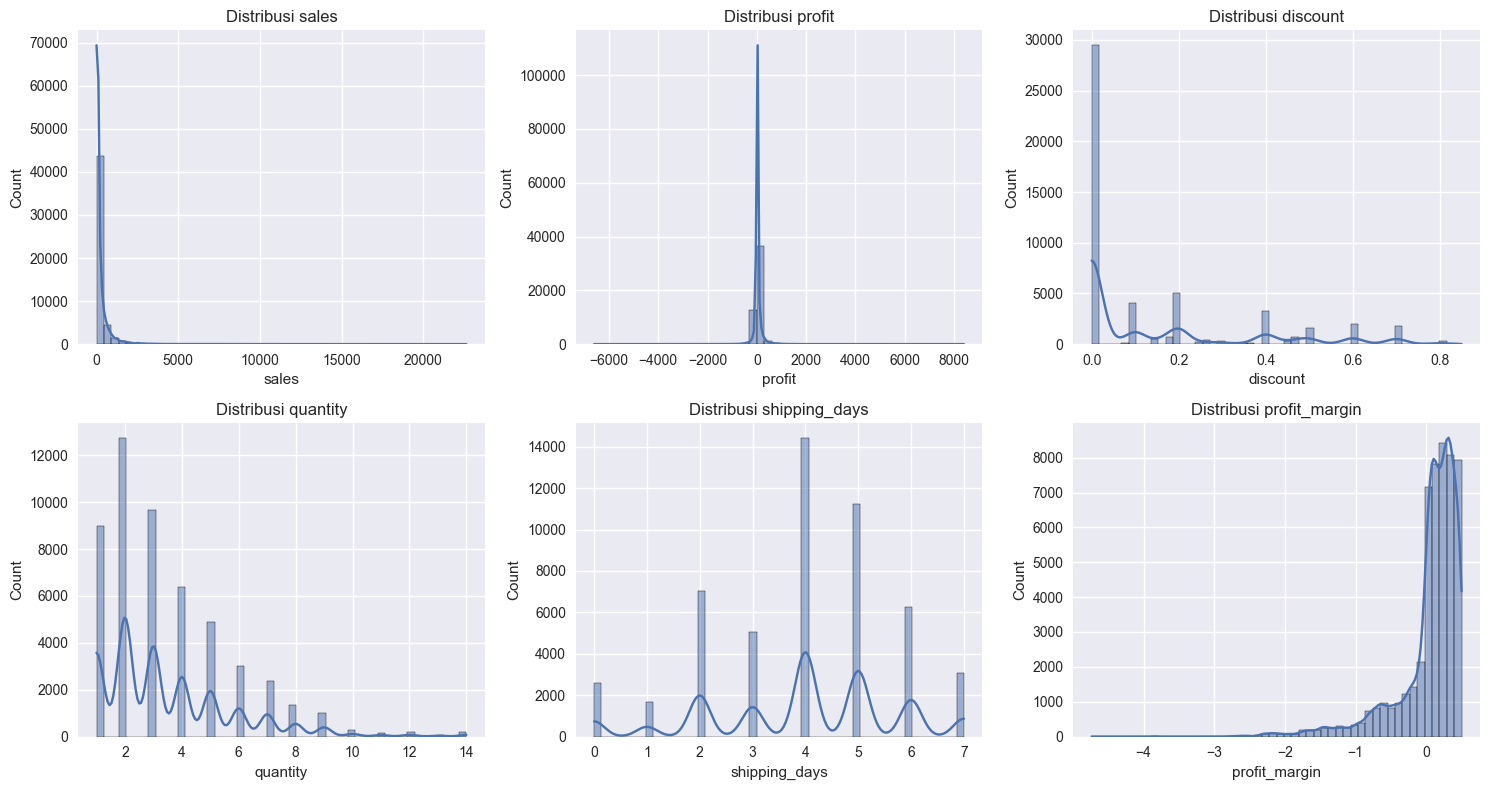

In [11]:
cols_to_plot = [
    c for c in ["sales", "profit", "discount", "quantity", "shipping_days", "profit_margin"]
    if c in df_clean.columns
]

print("Kolom numerik yang diplot:", cols_to_plot)

n = len(cols_to_plot)
ncols = 3                        # jumlah kolom plot (bisa 2 atau 3)
nrows = math.ceil(n / ncols)     # hitung baris yang dibutuhkan

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()            # supaya gampang di-loop

for i, col in enumerate(cols_to_plot):
    sns.histplot(df_clean[col].dropna(), bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f"Distribusi {col}")
    axes[i].set_xlabel(col)

# kalau ada axes yang tidak terpakai (misal 5 plot tapi grid 2x3 = 6 axes)
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(FIG_DIR / "numeric_distributions.png", bbox_inches="tight")
plt.show()

### Distribusi kategorikal (value counts)

In [12]:
cat_for_eda = [
    c for c in ["segment", "category", "sub_category", "region", "market", "order_priority"]
    if c in df_clean.columns
]

for col in cat_for_eda:
    print(f"\n=== {col.upper()} ===")
    display(df_clean[col].value_counts())


=== SEGMENT ===


segment
Consumer       26518
Corporate      15429
Home Office     9343
Name: count, dtype: int64


=== CATEGORY ===


category
Office Supplies    31273
Technology         10141
Furniture           9876
Name: count, dtype: int64


=== SUB_CATEGORY ===


sub_category
Binders        6152
Storage        5059
Art            4883
Paper          3538
Chairs         3434
Phones         3357
Furnishings    3170
Accessories    3075
Labels         2606
Envelopes      2435
Supplies       2425
Fasteners      2420
Bookcases      2411
Copiers        2223
Appliances     1755
Machines       1486
Tables          861
Name: count, dtype: int64


=== REGION ===


region
Central           11117
South              6645
EMEA               5029
North              4785
Africa             4587
Oceania            3487
West               3203
Southeast Asia     3129
East               2848
North Asia         2338
Central Asia       2048
Caribbean          1690
Canada              384
Name: count, dtype: int64


=== MARKET ===


market
APAC      11002
LATAM     10294
EU        10000
US         9994
EMEA       5029
Africa     4587
Canada      384
Name: count, dtype: int64


=== ORDER_PRIORITY ===


order_priority
Medium      29433
High        15501
Critical     3932
Low          2424
Name: count, dtype: int64

### Korelasi numerik & heatmap

In [13]:
corr = df_clean.select_dtypes(include=["number"]).corr()
display(corr)

,row_id,postal_code,sales,quantity,discount,profit,shipping_cost,order_year,order_month,order_quarter,shipping_days,profit_margin,sales_per_quantity
row_id,1.000000,0.009671,-0.043889,-0.173483,0.087594,-0.019037,-0.039078,-0.000921,-0.028695,-0.032242,-0.018082,-0.114042,0.020544
postal_code,0.009671,1.000000,-0.023854,0.012761,0.058443,-0.029961,-0.025449,0.004539,0.024627,0.025974,-0.010184,-0.064404,-0.024652
sales,-0.043889,-0.023854,1.000000,0.313577,-0.086722,0.484918,0.768073,-0.002905,0.001815,0.002372,-0.004660,0.074525,0.809084
quantity,-0.173483,0.012761,0.313577,1.000000,-0.019875,0.104365,0.272649,-0.005049,0.020611,0.022496,0.004347,0.050143,-0.010161
discount,0.087594,0.058443,-0.086722,-0.019875,1.000000,-0.316490,-0.079056,-0.005894,0.000027,0.000466,-0.001507,-0.847358,-0.115432
profit,-0.019037,-0.029961,0.484918,0.104365,-0.316490,1.000000,0.354441,0.002626,0.000140,0.000487,0.001745,0.358106,0.418647
shipping_cost,-0.039078,-0.025449,0.768073,0.272649,-0.079056,0.354441,1.000000,-0.003136,0.004929,0.005971,-0.142823,0.067621,0.631532
order_year,-0.000921,0.004539,-0.002905,-0.005049,-0.005894,0.002626,-0.003136,1.000000,-0.014193,-0.011695,-0.003427,0.006232,0.001601
order_month,-0.028695,0.024627,0.001815,0.020611,0.000027,0.000140,0.004929,-0.014193,1.000000,0.970096,0.005268,0.012005,-0.001332
order_quarter,-0.032242,0.025974,0.002372,0.022496,0.000466,0.000487,0.005971,-0.011695,0.970096,1.000000,0.005829,0.011527,-0.001495


[INFO] Figure disimpan ke: D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\reports\figures\corr_heatmap.png


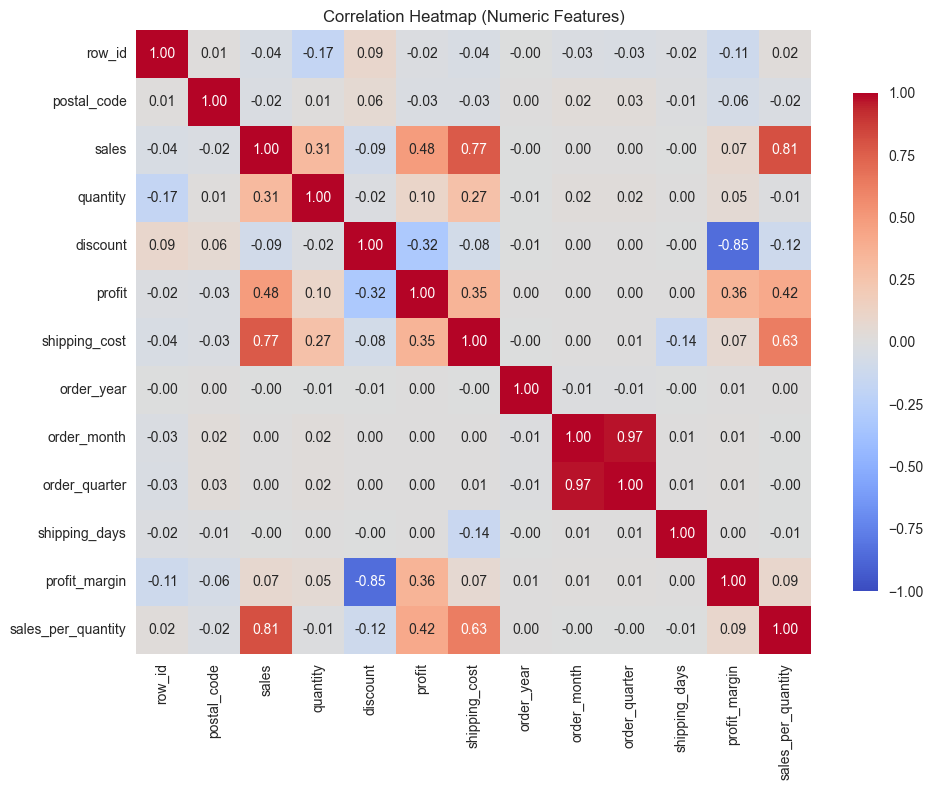

In [14]:
_ = plot_correlation_heatmap(
    df_clean,
    save_path="reports/figures/corr_heatmap.png",
)

### Visualisasi 1: Barplot Total Sales per Category

[INFO] Figure disimpan ke: D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\reports\figures\sales_by_category.png


D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\src\eda\eda_utils.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("category")["sales"]


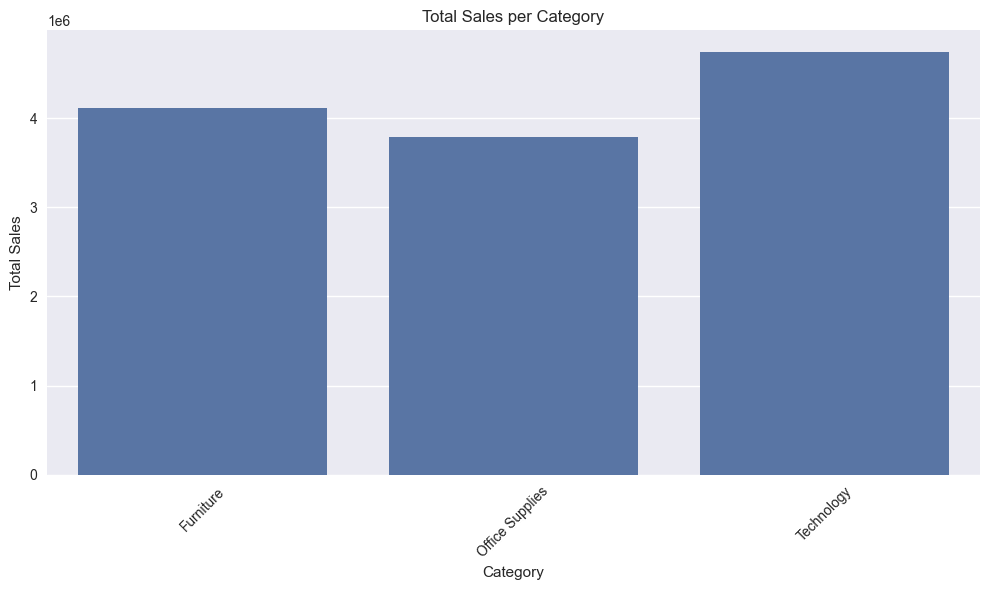

In [15]:
_ = plot_sales_by_category(
    df_clean,
    save_path="reports/figures/sales_by_category.png",
)

### Visualisasi 2: Sales & Profit per Sub-Category (Top 10)

C:\Users\acer\AppData\Local\Temp\ipykernel_17512\2878455405.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sub_category")[["sales", "profit"]]


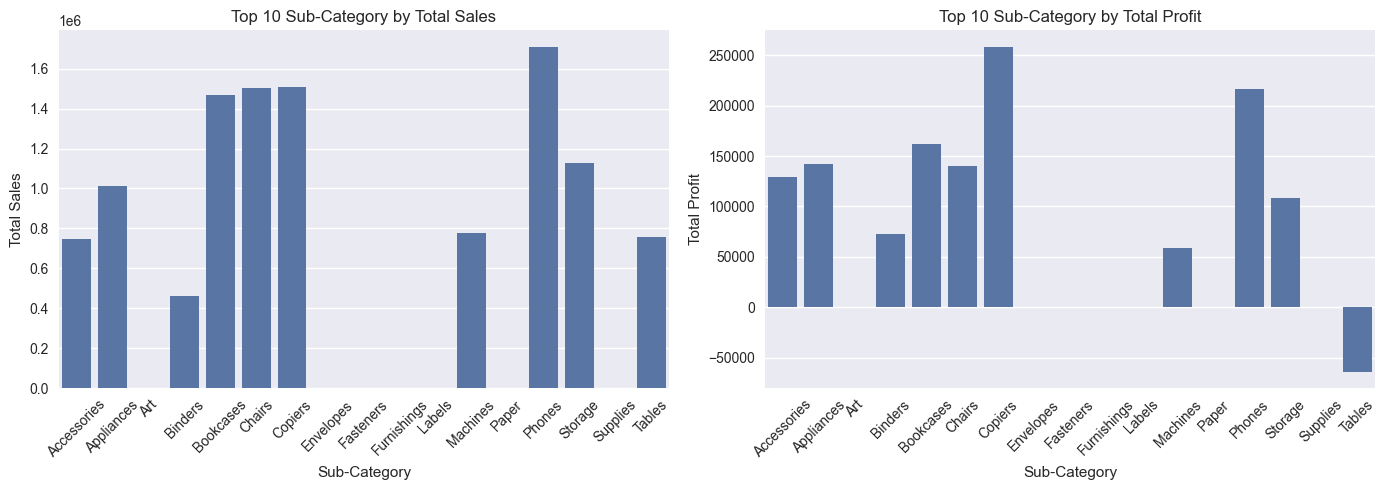

In [16]:
sub_agg = (
    df_clean
    .groupby("sub_category")[["sales", "profit"]]
    .sum()
    .sort_values(by="sales", ascending=False)
    .head(10)
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# --- Plot 1: Total Sales ---
sns.barplot(data=sub_agg, x="sub_category", y="sales", ax=axes[0])
axes[0].set_title("Top 10 Sub-Category by Total Sales")
axes[0].set_xlabel("Sub-Category")
axes[0].set_ylabel("Total Sales")
axes[0].tick_params(axis="x", rotation=45)

# --- Plot 2: Total Profit ---
sns.barplot(data=sub_agg, x="sub_category", y="profit", ax=axes[1])
axes[1].set_title("Top 10 Sub-Category by Total Profit")
axes[1].set_xlabel("Sub-Category")
axes[1].set_ylabel("Total Profit")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(FIG_DIR / "sales_profit_by_subcategory_separate.png", bbox_inches="tight")
plt.show()


### Visualisasi 3: Monthly Sales Trend

#### Matplotlib Version

C:\Users\acer\AppData\Local\Temp\ipykernel_17512\4224357192.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["sales"]


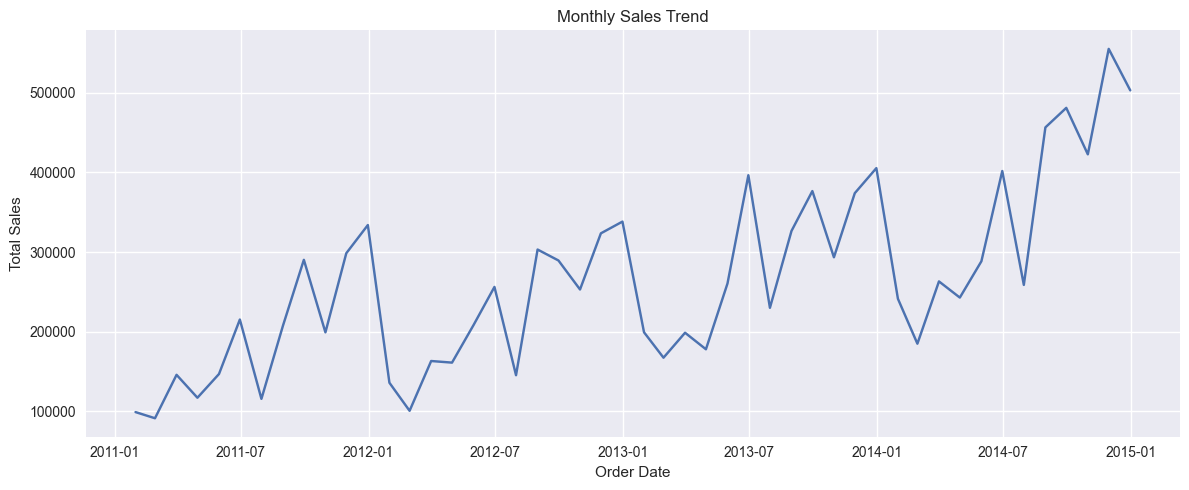

,order_date,sales
0,2011-01-31,98898.48886
1,2011-02-28,91152.15698
2,2011-03-31,145729.36736
3,2011-04-30,116915.76418
4,2011-05-31,146747.83610


In [17]:
if {"order_date", "sales"}.issubset(df_clean.columns):
    monthly_sales = (
        df_clean
        .set_index("order_date")
        .resample("M")["sales"]
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(12, 5))
    plt.plot(monthly_sales["order_date"], monthly_sales["sales"])
    plt.title("Monthly Sales Trend")
    plt.xlabel("Order Date")
    plt.ylabel("Total Sales")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "monthly_sales_trend.png", bbox_inches="tight")
    plt.show()

    display(monthly_sales.head())
else:
    print("Kolom order_date atau sales tidak ditemukan.")

#### Plotly Version (Interactive) - Bonus 1

In [20]:
if {"order_date", "sales"}.issubset(df_clean.columns):
    monthly_sales = (
        df_clean
        .set_index("order_date")
        .resample("M")["sales"]
        .sum()
        .reset_index()
    )

    fig = px.line(
        monthly_sales,
        x="order_date",
        y="sales",
        title="Monthly Sales Trend (Interactive)",
        labels={"order_date": "Order Date", "sales": "Total Sales"},
    )
    fig.show()
else:
    print("Kolom order_date atau sales tidak ditemukan.")

C:\Users\acer\AppData\Local\Temp\ipykernel_17512\813006811.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



#### Plot Interaktif by Region - Bonus 2

In [ ]:
if {"order_date", "sales", "region"}.issubset(df_clean.columns):
    monthly_region = (
        df_clean
        .set_index("order_date")
        .groupby("region")["sales"]
        .resample("M")
        .sum()
        .reset_index()
    )

    fig = px.line(
        monthly_region,
        x="order_date",
        y="sales",
        color="region",
        title="Monthly Sales Trend by Region (Interactive)",
        labels={"order_date": "Order Date", "sales": "Total Sales", "region": "Region"},
    )
    fig.show()
else:
    print("Kolom order_date / sales / region tidak lengkap.")

C:\Users\acer\AppData\Local\Temp\ipykernel_17512\4046031646.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\acer\AppData\Local\Temp\ipykernel_17512\4046031646.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



### Visualisasi 4: Scatter Discount vs Profit

[INFO] Figure disimpan ke: D:\Coding\git-repo\github\tubes-pda\tubes-if5100-global-superstore\reports\figures\discount_vs_profit.png


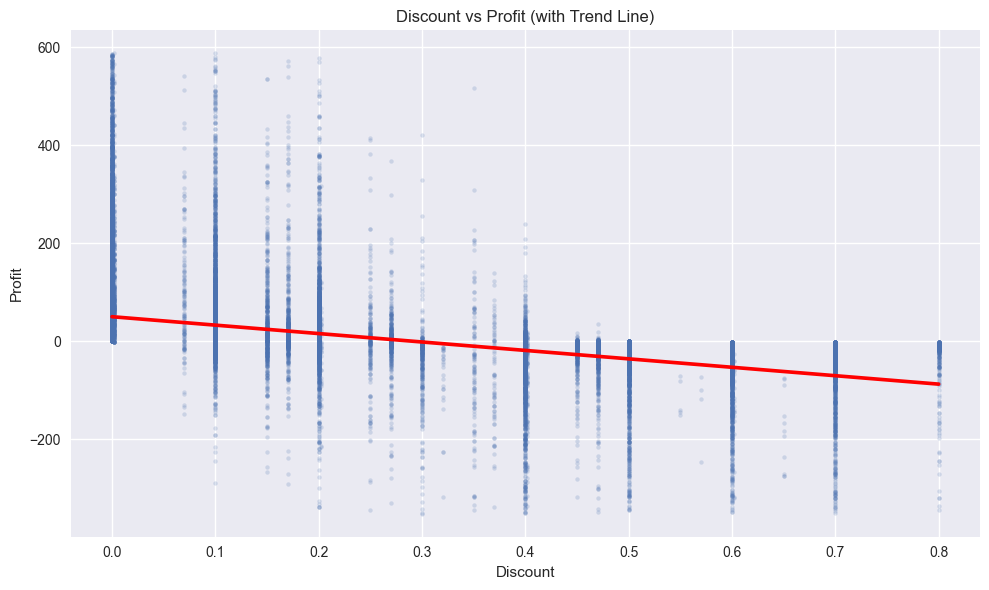

In [18]:
_ = plot_discount_vs_profit(
    df_clean,
    save_path="reports/figures/discount_vs_profit.png",
)